In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/인공지능물리학/프로젝트/증강데이터')
filepaths = list(dir_.glob(r'**/*.png'))
def proc_img(filepath):
   	# 이미지데이터의 경로와 label데이터로 데이터프레임 만들기

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head()


,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/인공지능물리학...,alpha
1,/content/drive/MyDrive/Colab Notebooks/인공지능물리학...,alpha
2,/content/drive/MyDrive/Colab Notebooks/인공지능물리학...,muon
3,/content/drive/MyDrive/Colab Notebooks/인공지능물리학...,alpha
4,/content/drive/MyDrive/Colab Notebooks/인공지능물리학...,muon


In [4]:
# 라벨확인

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1500

Number of different labels: 3

Labels: ['alpha' 'muon' 'beta']


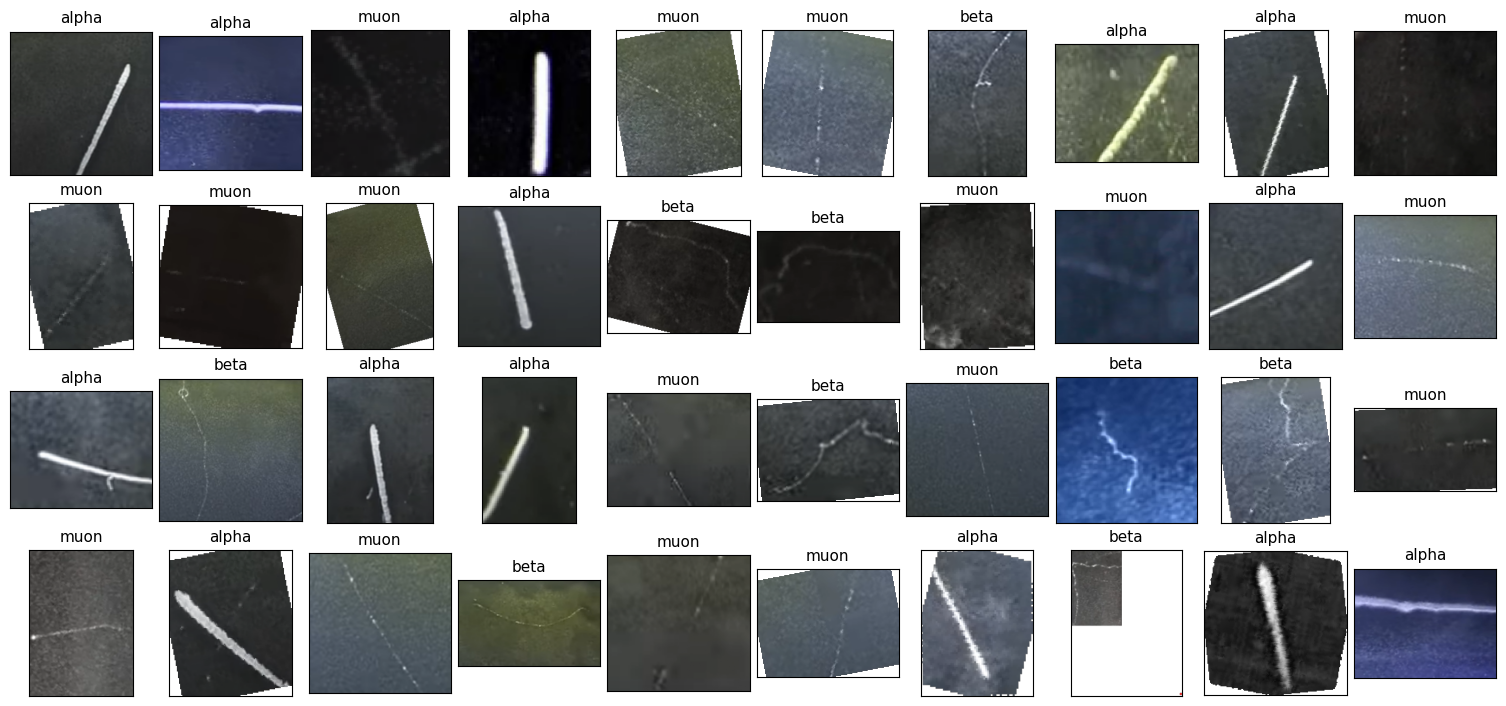

In [5]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 11)

plt.tight_layout(pad=0.5)
plt.show()

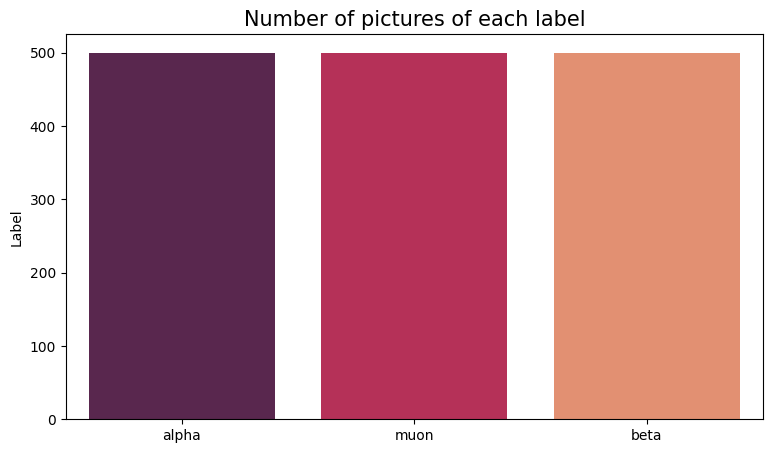

In [6]:
# 라벨 데이터 확인

vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each label", fontsize = 15)
plt.show()

In [7]:
# 트레이닝셋 스플릿(9:1)

train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1350, 2), (150, 2))

In [8]:
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/인공지능물리학/프로젝트/증강데이터',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/인공지능물리학/프로젝트/증강데이터',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# CNN 모델 구성
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15
38/38 [==============================] - 506s 13s/step - loss: 1.0851 - accuracy: 0.4183 - val_loss: 0.8870 - val_accuracy: 0.5867
Epoch 2/15
38/38 [==============================] - 58s 1s/step - loss: 0.8035 - accuracy: 0.6242 - val_loss: 0.7208 - val_accuracy: 0.6533
Epoch 3/15
38/38 [==============================] - 57s 2s/step - loss: 0.6178 - accuracy: 0.7142 - val_loss: 0.7500 - val_accuracy: 0.6533
Epoch 4/15
38/38 [==============================] - 61s 2s/step - loss: 0.5489 - accuracy: 0.7558 - val_loss: 0.5528 - val_accuracy: 0.7300
Epoch 5/15
38/38 [==============================] - 65s 2s/step - loss: 0.4752 - accuracy: 0.7933 - val_loss: 0.6334 - val_accuracy: 0.7467
Epoch 6/15
38/38 [==============================] - 59s 2s/step - loss: 0.4012 - accuracy: 0.8358 - val_loss: 0.6213 - val_accuracy: 0.7500
Epoch 7/15
38/38 [==============================] - 59s 2s/step - loss: 0.3500 - accuracy: 0.8633 - val_loss: 0.5345 - val_accuracy: 0.7900
Epoch 8/15
38/38 [

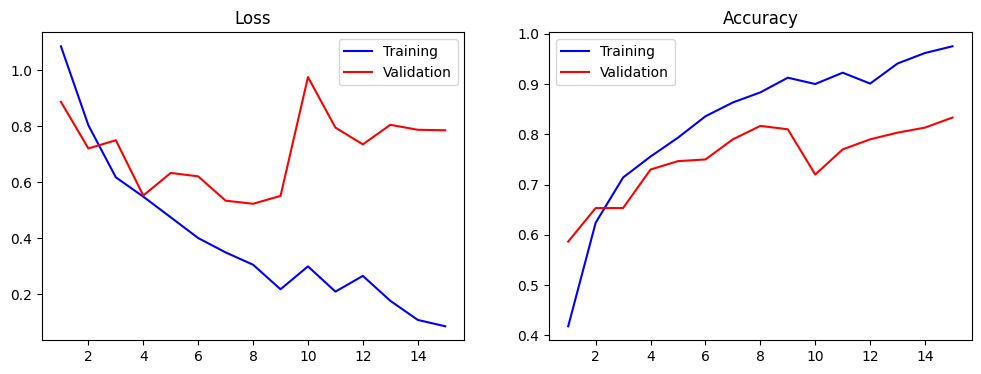

In [10]:
# 손실함수, 정확도 그래프 그리기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 15)

In [31]:
# RESNET 모델
RN50_2 = tf.keras.applications.resnet_v2.ResNet50V2(weights="imagenet",
                                          include_top=False,
                                          input_shape=(150, 150, 3))

RN50_2.trainable = False # 이미 학습된 가중치만을 사용

In [12]:
# RESNET 모델 구성
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential(name="ResNet50v2_RT")
model.add(RN50_2)

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(3, activation = 'softmax'))

model.summary()

Model: "ResNet50v2_RT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               26214912  
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 49781251 (189.90 MB)
Trainable params: 26216451 (100.01 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
from tensorflow.keras import optimizers

# RESNET 모델 컴파일
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.00005),
              metrics = ['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15
38/38 [==============================] - 130s 3s/step - loss: 0.3783 - accuracy: 0.8542 - val_loss: 0.1318 - val_accuracy: 0.9700
Epoch 2/15
38/38 [==============================] - 147s 4s/step - loss: 0.0214 - accuracy: 0.9950 - val_loss: 0.1373 - val_accuracy: 0.9533
Epoch 3/15
38/38 [==============================] - 144s 4s/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.1033 - val_accuracy: 0.9633
Epoch 4/15
38/38 [==============================] - 146s 4s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9600
Epoch 5/15
38/38 [==============================] - 147s 4s/step - loss: 8.9687e-04 - accuracy: 1.0000 - val_loss: 0.1103 - val_accuracy: 0.9633
Epoch 6/15
38/38 [==============================] - 143s 4s/step - loss: 7.2629e-04 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 0.9633
Epoch 7/15
38/38 [==============================] - 144s 4s/step - loss: 6.1344e-04 - accuracy: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.9633
E

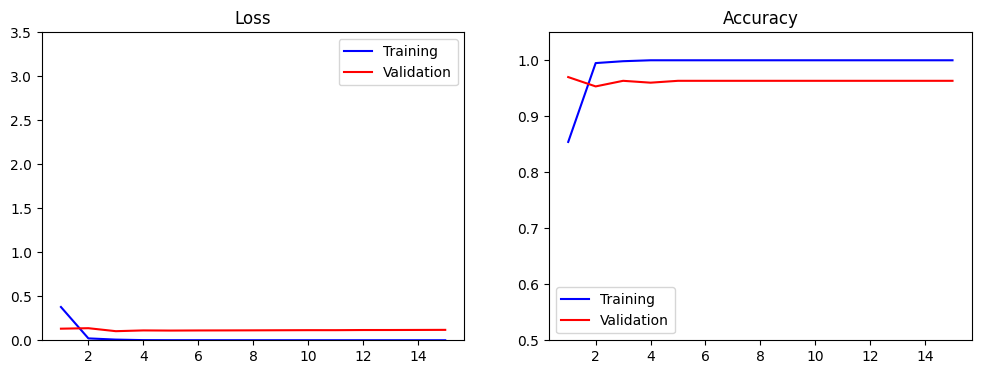

In [14]:
# 손실함수, 정확도 그래프 그리기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')
    axes[0].set_ylim([0, 3.5])  # y 축 범위 설정
    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')
    axes[1].set_ylim([0.5, 1.05])  # y 축 범위 설정
    plt.show()

plot_loss_acc(history, 15)

In [25]:
# RESNET WITH GAP 모델 구성
model = models.Sequential(name="ResNet50v2_RT_with_GAP")
model.add(RN50_2)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "ResNet50v2_RT_with_GAP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24615427 (93.90 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [26]:
# RESNET WITH GAP 모델 컴파일
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.00005),
              metrics = ['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15
38/38 [==============================] - 117s 3s/step - loss: 0.6790 - accuracy: 0.7183 - val_loss: 0.4059 - val_accuracy: 0.8867
Epoch 2/15
38/38 [==============================] - 130s 3s/step - loss: 0.3354 - accuracy: 0.9008 - val_loss: 0.2653 - val_accuracy: 0.9333
Epoch 3/15
38/38 [==============================] - 127s 3s/step - loss: 0.2389 - accuracy: 0.9317 - val_loss: 0.2183 - val_accuracy: 0.9433
Epoch 4/15
38/38 [==============================] - 113s 3s/step - loss: 0.1862 - accuracy: 0.9517 - val_loss: 0.1941 - val_accuracy: 0.9367
Epoch 5/15
38/38 [==============================] - 130s 3s/step - loss: 0.1542 - accuracy: 0.9608 - val_loss: 0.1774 - val_accuracy: 0.9400
Epoch 6/15
38/38 [==============================] - 135s 4s/step - loss: 0.1287 - accuracy: 0.9725 - val_loss: 0.1601 - val_accuracy: 0.9533
Epoch 7/15
38/38 [==============================] - 130s 3s/step - loss: 0.1092 - accuracy: 0.9767 - val_loss: 0.1499 - val_accuracy: 0.9600
Epoch 8/15
38

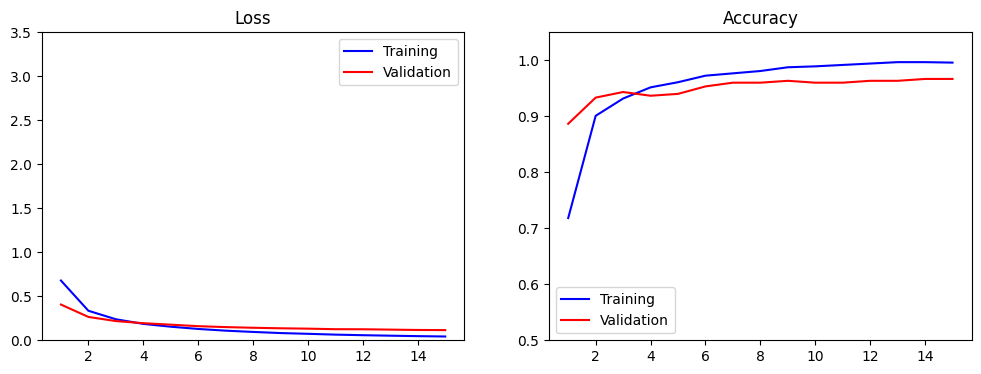

In [27]:
# 손실함수, 정확도 그래프 그리기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')
    axes[0].set_ylim([0, 3.5])  # y 축 범위 설정
    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')
    axes[1].set_ylim([0.5, 1.05])  # y 축 범위 설정
    plt.show()

plot_loss_acc(history, 15)

In [32]:
# RESNET WITH DROPOUT 모델 구성

model = models.Sequential(name="ResNet50v2_RT")
model.add(RN50_2)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  # Dropout 추가
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(3, activation = 'softmax'))

model.summary()

Model: "ResNet50v2_RT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               26214912  
                                                                 
 dense_9 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 49781251 (189.90 MB)
Trainable params: 26216451 (100.01 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [33]:
# RESNET WITH DROPOUT 모델 컴파일
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.00005),
              metrics = ['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15
38/38 [==============================] - 152s 4s/step - loss: 0.6460 - accuracy: 0.7942 - val_loss: 0.2053 - val_accuracy: 0.9233
Epoch 2/15
38/38 [==============================] - 141s 4s/step - loss: 0.1038 - accuracy: 0.9633 - val_loss: 0.1232 - val_accuracy: 0.9433
Epoch 3/15
38/38 [==============================] - 143s 4s/step - loss: 0.0401 - accuracy: 0.9867 - val_loss: 0.0982 - val_accuracy: 0.9633
Epoch 4/15
38/38 [==============================] - 126s 3s/step - loss: 0.0238 - accuracy: 0.9892 - val_loss: 0.1022 - val_accuracy: 0.9633
Epoch 5/15
38/38 [==============================] - 141s 4s/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 0.0967 - val_accuracy: 0.9700
Epoch 6/15
38/38 [==============================] - 142s 4s/step - loss: 0.0208 - accuracy: 0.9950 - val_loss: 0.1119 - val_accuracy: 0.9567
Epoch 7/15
38/38 [==============================] - 143s 4s/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 0.0963 - val_accuracy: 0.9667
Epoch 8/15
38

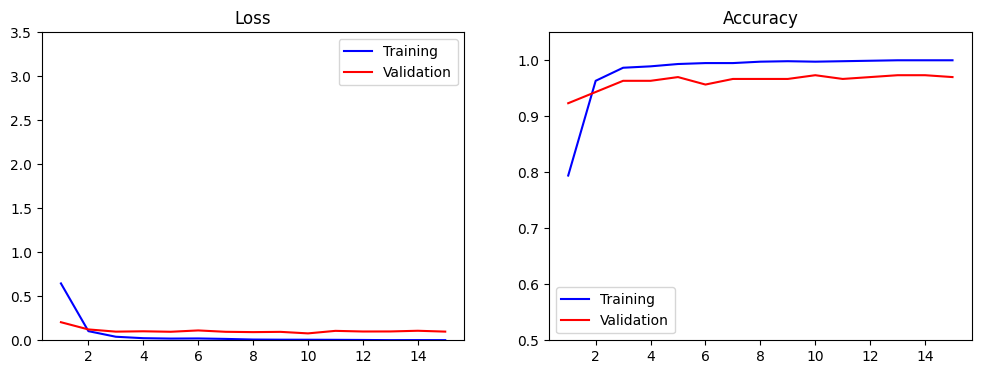

In [34]:
# 손실함수, 정확도 그래프 그리기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')
    axes[0].set_ylim([0, 3.5])  # y 축 범위 설정
    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')
    axes[1].set_ylim([0.5, 1.05])  # y 축 범위 설정
    plt.show()

plot_loss_acc(history, 15)

In [45]:
# 분류해보기

from tensorflow.keras.preprocessing import image

# 새로운 이미지를 불러옴
new_image_path = Path('/content/drive/MyDrive/Colab Notebooks/인공지능물리학/프로젝트/분류해볼거/KakaoTalk_20231208_165604246_02.png')

# 이미지를 모델 입력에 맞게 전처리
img = image.load_img(new_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # 모델 학습 시 이미지를 rescale 했으므로 여기서도 같은 작업을 수행

# 이미지를 모델에 입력하여 예측 수행
predictions = model.predict(img_array)

# 예측 결과 확인
predicted_class = np.argmax(predictions)  # 가장 높은 확률의 클래스 선택

if predicted_class == 0:
    print('predict : alpha')
elif predicted_class == 1:
    print('predict : beta')
elif predicted_class == 2:
    print('predict : muon')

# 예측확률

classes = ['alpha', 'beta', 'muon']

# 각 클래스에 대한 예측 확률 출력
for i, class_name in enumerate(classes):
    print(f'Predicted probability for class {class_name}: {predictions[0][i]}')

1/1 [==============================] - 0s 112ms/step
predict : muon
Predicted probability for class alpha: 0.00011635079863481224
Predicted probability for class beta: 0.1584213823080063
Predicted probability for class muon: 0.841462254524231


In [36]:
# 예측확률

classes = ['alpha', 'beta', 'muon']

# 각 클래스에 대한 예측 확률 출력
for i, class_name in enumerate(classes):
    print(f'Predicted probability for class {class_name}: {predictions[0][i]}')

Predicted probability for class alpha: 0.00011635079863481224
Predicted probability for class beta: 0.1584213823080063
Predicted probability for class muon: 0.841462254524231


In [41]:
# 테스트 데이터 확인

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(150, 150),
                                                  batch_size=75)

loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Found 150 validated image filenames belonging to 3 classes.
2/2 [==============================] - 10s 5s/step - loss: 0.0034 - accuracy: 1.0000
Loss = 0.00342
Accuracy = 1.00000


In [51]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}


def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_gen,validation_data=val_gen,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

DenseNet121          trained in 149.18 sec
MobileNetV2          trained in 44.83 sec
DenseNet201          trained in 171.96 sec
16705208/16705208 [==============================] - 1s 0us/step
EfficientNetB0       trained in 89.39 sec
27018416/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 94.36 sec
87910968/87910968 [==============================] - 3s 0us/step
InceptionV3          trained in 87.52 sec
12683000/12683000 [==============================] - 1s 0us/step
MobileNetV3Large     trained in 25.8 sec
234545216/234545216 [==============================] - 7s 0us/step
ResNet152V2          trained in 394.11 sec
94765736/94765736 [==============================] - 3s 0us/step
ResNet50             trained in 147.08 sec
ResNet50V2           trained in 146.18 sec
80134624/80134624 [==============================] - 3s 0us/step
VGG19                trained in 510.18 sec
58889256/58889256 [==============================] - 2s 0us/step
VGG16      

In [66]:
# 모델명과 해당 모델의 퍼포먼스 초기값을 딕셔너리로 정의합니다.
models_dict = {
    "DenseNet121": {"model": tf.keras.applications.DenseNet121, "perf": 0},
    "DenseNet201": {"model": tf.keras.applications.DenseNet201, "perf": 0},
    "EfficientNetB0": {"model": tf.keras.applications.EfficientNetB0, "perf": 0},
    "EfficientNetB1": {"model": tf.keras.applications.EfficientNetB1, "perf": 0},
    "InceptionV3": {"model": tf.keras.applications.InceptionV3, "perf": 0},
    "MobileNetV2": {"model": tf.keras.applications.MobileNetV2, "perf": 0},
    "MobileNetV3Large": {"model": tf.keras.applications.MobileNetV3Large, "perf": 0},
    "ResNet152V2": {"model": tf.keras.applications.ResNet152V2, "perf": 0},
    "ResNet50": {"model": tf.keras.applications.ResNet50, "perf": 0},
    "ResNet50V2": {"model": tf.keras.applications.ResNet50V2, "perf": 0},
    "VGG19": {"model": tf.keras.applications.VGG19, "perf": 0},
    "VGG16": {"model": tf.keras.applications.VGG16, "perf": 0},
    "Xception": {"model": tf.keras.applications.Xception, "perf": 0}
}

# 모델 목록을 순회하며 각 모델을 학습합니다.
for model_name, model_info in models_dict.items():
    # 모델 생성
    model = get_model(model_info["model"])


    # 모델 학습
    history = model.fit(train_gen, validation_data=val_gen, epochs=1)

    # 학습 완료 후 해당 모델의 퍼포먼스를 저장합니다.
    models_dict[model_name]["perf"] = history.history['accuracy'][-1]  # 예시로 'accuracy'의 마지막 값 저장

# 각 모델에 대한 학습이 완료된 후, 퍼포먼스를 출력하거나 필요한 추가 작업을 수행할 수 있습니다.
print(models_dict)  # 퍼포먼스 출력 (예시)

38/38 [==============================] - 145s 4s/step - loss: 0.5274 - accuracy: 0.7758 - val_loss: 0.2007 - val_accuracy: 0.9433
{'DenseNet121': {'model': <function DenseNet121 at 0x7d215b66d510>, 'perf': 0.7883333563804626}, 'DenseNet201': {'model': <function DenseNet201 at 0x7d215b66d630>, 'perf': 0.7858333587646484}, 'EfficientNetB0': {'model': <function EfficientNetB0 at 0x7d215b66d990>, 'perf': 0.335833340883255}, 'EfficientNetB1': {'model': <function EfficientNetB1 at 0x7d215b66da20>, 'perf': 0.3233333230018616}, 'InceptionV3': {'model': <function InceptionV3 at 0x7d215b66f250>, 'perf': 0.7691666483879089}, 'MobileNetV2': {'model': <function MobileNetV2 at 0x7d215b66f910>, 'perf': 0.7908333539962769}, 'MobileNetV3Large': {'model': <function MobileNetV3Large at 0x7d215b6980d0>, 'perf': 0.4908333420753479}, 'ResNet152V2': {'model': <function ResNet152V2 at 0x7d215b69a5f0>, 'perf': 0.8224999904632568}, 'ResNet50': {'model': <function ResNet50 at 0x7d215b6995a0>, 'perf': 0.422500014

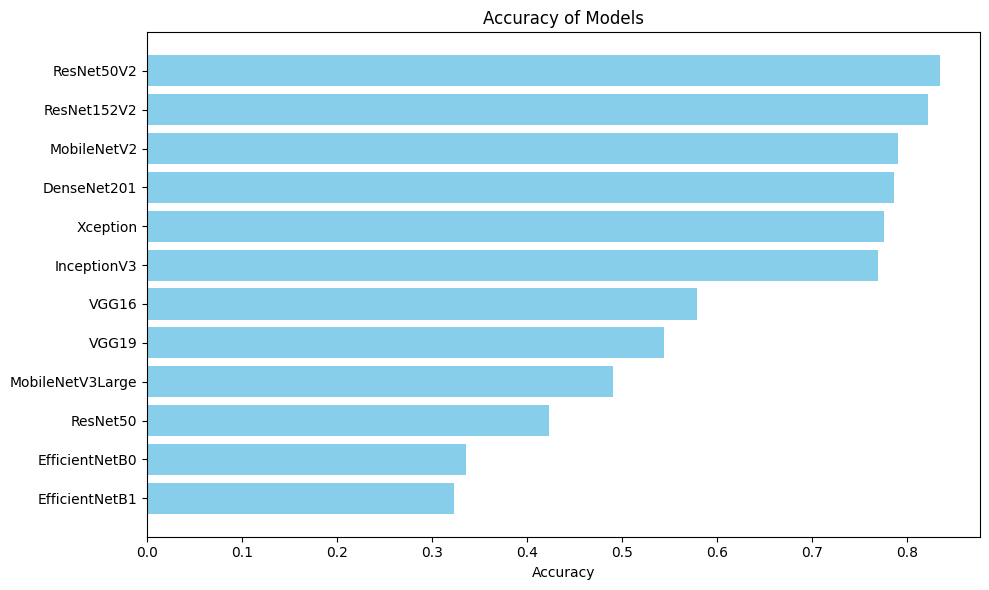

In [69]:
# 모델 이름과 정확도 데이터
model_names = [
    "MobileNetV2", "DenseNet201", "EfficientNetB0", "EfficientNetB1", "InceptionV3",
    "MobileNetV2", "MobileNetV3Large", "ResNet152V2", "ResNet50", "ResNet50V2",
    "VGG19", "VGG16", "Xception"
]

accuracies = [
    0.7883, 0.7858, 0.3358, 0.3233, 0.7692,
    0.7908, 0.4908, 0.8225, 0.4225, 0.8350,
    0.5442, 0.5792, 0.7758
]

# 정확도를 기준으로 내림차순 정렬
sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k], reverse=True)
sorted_accuracies = [accuracies[i] for i in sorted_indices]
sorted_model_names = [model_names[i] for i in sorted_indices]

# 정확도를 내림차순으로 그래프 플로팅
plt.figure(figsize=(10, 6))
plt.barh(sorted_model_names, sorted_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy of Models')
plt.gca().invert_yaxis()  # 내림차순으로 표시
plt.tight_layout()
plt.show()

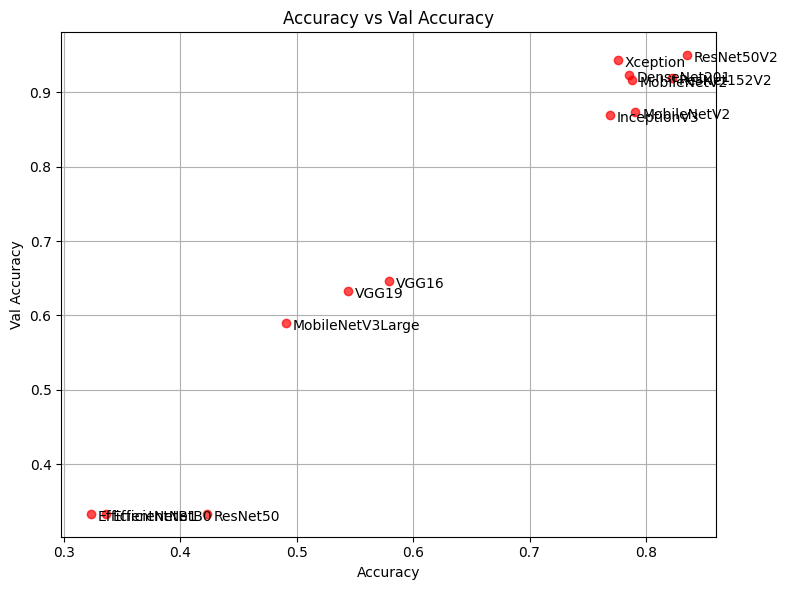

In [68]:

# 모델 이름과 정확도, val_accuracy 데이터
model_names = [
    "MobileNetV2", "DenseNet201", "EfficientNetB0", "EfficientNetB1", "InceptionV3",
    "MobileNetV2", "MobileNetV3Large", "ResNet152V2", "ResNet50", "ResNet50V2",
    "VGG19", "VGG16", "Xception"
]

accuracies = [
    0.7883, 0.7858, 0.3358, 0.3233, 0.7692,
    0.7908, 0.4908, 0.8225, 0.4225, 0.8350,
    0.5442, 0.5792, 0.7758
]

val_accuracies = [
    0.9167, 0.9233, 0.3333, 0.3333, 0.8700,
    0.8733, 0.5900, 0.9200, 0.3333, 0.9500,
    0.6333, 0.6467, 0.9433
]

# 그래프
plt.figure(figsize=(8, 6))
plt.scatter(accuracies, val_accuracies, c='red', alpha=0.7)
plt.xlabel('Accuracy')
plt.ylabel('Val Accuracy')
plt.title('Accuracy vs Val Accuracy')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (accuracies[i], val_accuracies[i]), xytext=(5, -5), textcoords='offset points')
plt.grid(True)
plt.tight_layout()
plt.show()